# Pipeline for image size estimation

Imports

In [1]:
# basics
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
# file work
import os
import json
# computer vision
import cv2
import torch
import laser_detection as ld
# models
from segment_anything import sam_model_registry, SamPredictor
from easy_ViTPose import VitInference
from huggingface_hub import hf_hub_download

/cluster/tufts/fuzzywuzzy/jbrand12/condaenv/fzwz/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 0: Assign input point to each image

run: 'python3 label.py' to get json of image names and input points (change path to folder in script)

## Step 1: Load image data from json

The below are modifiable variables you can change depending on what dataset you are running

In [2]:
# ALL DATA
json_file = '../data/perfect.json'  # must contain input labels
image_folder = '../data/perfect'
mask_folder = '../data/perfect_masks'  # can be empty to start

# SAMPLE DATA
# json_file = 'sample_data/red_lasers/sample_data.json'  # must contain input labels
# image_folder = 'sample_data/red_lasers/sample_data'
# mask_folder = 'sample_data/red_lasers/sample_data_masks'  # can be empty to start

# load data
with open(json_file, 'r') as file:
    image_data = json.load(file)

In [3]:
len(image_data)

72

## Step 2: Run images through SAM to prep for laser detection

### ***only need to run this code once to get masks!!!

Set up SAM

In [4]:
# select checkpoint and model type
sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

# define predictor
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

# change device if cuda is available
if torch.cuda.is_available():
    sam.to(device='cuda')

predictor = SamPredictor(sam)

In [5]:
def generate_mask(im, input_point):
    input_label = np.array([1])
    predictor.set_image(im)
    masks, scores, _ = predictor.predict(point_coords=input_point, point_labels=input_label, multimask_output=True)
    # return best mask
    return masks[np.argmax(scores)]

Iterate through images and get mask

In [6]:
from tqdm import tqdm
# iterate through each entry in the JSON data
for image_name, im_data in tqdm(image_data.items(), desc="SAM"):
    image_path = os.path.join(image_folder, image_name)
    
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if img is not None:
        # extract coordinates
        input_point = np.array([im_data['input_point']])
        # Generate the mask
        mask = generate_mask(img, input_point)
        mask = mask.astype(np.uint8)
        
        # Define the mask filename
        mask_filename = os.path.splitext(image_name)[0] + "_mask.png"
        mask_path = os.path.join(mask_folder, mask_filename)
        
        # Save the mask
        cv2.imwrite(mask_path, mask)
        
        # Update the JSON data with the mask filename
        image_data[image_name]['mask'] = mask_filename

Processing Images: 100%|██████████| 72/72 [00:45<00:00,  1.60it/s]


## Step 3: laser point detection

In [7]:
idx = 0
# iterate through each entry in json
for image_name, info in tqdm(image_data.items(), desc="Laser Detection"):
    image_path = os.path.join(image_folder, image_name)
    # load image
    source = cv2.imread(image_path)

    # Load the mask
    mask_filename = info['mask']
    mask_path = os.path.join(mask_folder, mask_filename)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale
    mask = mask > 0  # need to convert to boolean values

    if source is not None:
        # run laser detection image
        points = ld.detect_red_laser_points(source, mask)
        
        # Update the JSON data with the mask filename
        image_data[image_name]['laser_points'] = points

detecting lasers: 100%|██████████| 72/72 [07:57<00:00,  6.63s/it]


### Step 4: Run VitPose

In [8]:
# define model parameters
MODEL_SIZE = 'h'
YOLO_SIZE = 'n'
DATASET = 'apt36k'
ext = '.pth'
ext_yolo = '.pt'

# download model_path and yolo_path
MODEL_TYPE = "torch"
YOLO_TYPE = "torch"
REPO_ID = 'JunkyByte/easy_ViTPose'
FILENAME = os.path.join(MODEL_TYPE, 
                        f'{DATASET}/vitpose-' + MODEL_SIZE + f'-{DATASET}') + ext
FILENAME_YOLO = 'yolov8/yolov8' + YOLO_SIZE + ext_yolo
print(f'Downloading model {REPO_ID}/{FILENAME}')
model_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
yolo_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME_YOLO)

In [9]:
# initialize model
model = VitInference(model_path, yolo_path, MODEL_SIZE, dataset=DATASET)

In [10]:
count = 0
# iterate through each entry in json
for image_name, info in tqdm(image_data.items(), desc="ViTPose"):
    image_path = os.path.join(image_folder, image_name)
    # load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting

    # get keypoints
    img_arr = np.array(img, dtype=np.uint8)
    keypoints = model.inference(img_arr)

    if keypoints:
        # store results
        shoulder = (int(keypoints[0][3][1]), int(keypoints[0][3][0]))
        rump = (int(keypoints[0][4][1]), int(keypoints[0][4][0]))
      
        # Update the JSON data with shoulder and rump
        image_data[image_name]['shoulder_rump'] = [shoulder, rump]
    else:
        count += 1
        # TODO how do we want to handle this case in the json?
        image_data[image_name]['shoulder_rump'] = None

print(f"vitpose failed for {count} images")

ViTPose: 100%|██████████| 72/72 [00:12<00:00,  5.64it/s]

vitpose failed for 3 images


### Step 5: get distances

In [11]:
measured_df = pd.read_csv('../data/measured.csv')
measured_df = measured_df.dropna(subset=['PhotoID', 'Laser Width', 'BodyLength1'])

Get dictionaries for conversions

In [12]:
laser_width = dict(zip(measured_df['PhotoID'], measured_df['Laser Width']))
body_length = dict(zip(measured_df['PhotoID'], measured_df['BodyLength1']))
pix_laser = dict(zip(measured_df['PhotoID'], measured_df['PixLaser1']))
pix_length = dict(zip(measured_df['PhotoID'], measured_df['PixLength1']))

In [15]:
# iterate through each entry in json
count = 0
errors = []
for image_name, info in tqdm(image_data.items(), desc="Calculating Final Distances"):
    try:
        # distances in pixels
        laser_points = info['laser_points']
        body_points = info['shoulder_rump']

        # calculate ratio
        laser_dist = round(math.dist(laser_points[0], laser_points[1]), 1)
        body_dist = round(math.dist(body_points[0], body_points[1]), 1)
        ratio = laser_dist / body_dist

        # lookup laser width
        photo_id = image_name.split('.')[0]
        laser_in = laser_width[photo_id]
        # compare results
        predicted_length = laser_in / ratio
        true_length = body_length[photo_id]
        error = round(abs(predicted_length - true_length) / true_length, 3)
        errors.append(error * 100)
        print(f"Predicted: {predicted_length}\t Actual: {true_length}\t Error = {error}")
        
        if error < 0.10:
            count += 1
    except:
        pass

print(f"{count} / {len(image_data)} images with less than 10 percent error")

Calculating Final Distances: 100%|██████████| 72/72 [00:00<00:00, 58142.07it/s]

Predicted: 64.5276614832536	 Actual: 63.20911765	 Error = 0.021
Predicted: 89.37468982630273	 Actual: 27.38267717	 Error = 2.264
Predicted: 63.44714285714284	 Actual: 62.64761905	 Error = 0.013
Predicted: 46.3542	 Actual: 47.13861386	 Error = 0.017
Predicted: 56.639354838709664	 Actual: 54.55	 Error = 0.038
Predicted: 25.9396875	 Actual: 26.90520833	 Error = 0.036
Predicted: 40.85481481481481	 Actual: 39.61111111	 Error = 0.031
Predicted: 42.145133899412144	 Actual: 44.34640523	 Error = 0.05
Predicted: 62.02759259259258	 Actual: 65.89074074	 Error = 0.059
Predicted: 16.897756686798964	 Actual: 37.86153846	 Error = 0.554
Predicted: 71.14347222222221	 Actual: 59.07103825	 Error = 0.204
Predicted: 49.802040816326524	 Actual: 59.38181818	 Error = 0.161
Predicted: 52.73015384615384	 Actual: 53.85538462	 Error = 0.021
Predicted: 64.90015873015872	 Actual: 63.465625	 Error = 0.023
Predicted: 54.471968503937006	 Actual: 60.92283465	 Error = 0.106
Predicted: 52.32323076923077	 Actual: 58.360305

In [16]:
print("mean:", np.mean(errors))
print("median:", np.median(errors))
print("std:", np.std(errors))

mean: 46.74354838709678
median: 5.45
std: 97.7629153599002


In [23]:
sorted(errors, reverse=True)[:8]

[460.40000000000003,
 327.8,
 322.1,
 318.0,
 307.4,
 226.39999999999998,
 140.0,
 86.9]

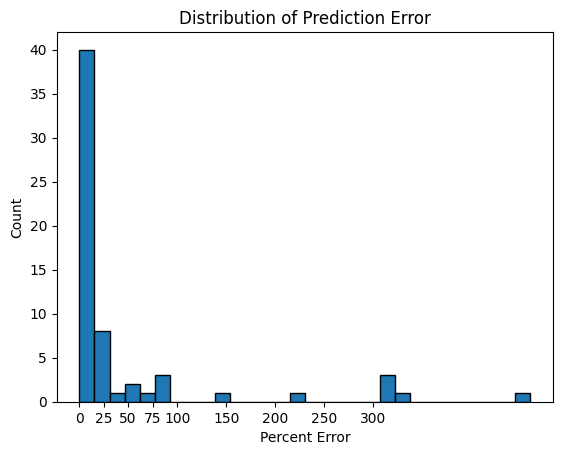

In [18]:
import matplotlib.pyplot as plt
plt.hist(errors, bins=30, edgecolor='black')
plt.xlabel("Percent Error")
plt.xticks([0,25,50,75,100,150,200,250,300])
plt.ylabel("Count")
plt.title("Distribution of Prediction Error")
plt.show()

### Save final results

In [19]:
# Write the updated JSON data to a file
with open(json_file, 'w') as file:
    json.dump(image_data, file, indent=4)

print(f"Updated data saved to {json_file}")

Updated data saved to ../data/perfect.json
